In [1]:
#use wdtools_env_pip environment 

import matplotlib.pyplot as plt
import numpy as np
import scipy
from tqdm import tqdm
import pandas as pd
#pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# Suppress SettingWithCopyWarnings
pd.options.mode.chained_assignment = None  # default='warn'

#for multiprocessing
from joblib import Parallel, delayed

plt.style.use('Software/stefan.mplstyle')

import sys
import os
sys.path.append('Software')
# import wdtools
# from wdtools.gfp import GFP
# from wdtools.spectrum import SpecTools
# from wdtools.parametric import LineProfiles
# from wdtools.gaia import *
# from wdtools.corr3d import *
from wdtools_nicole.parametric import LineProfiles
from corv_nicole.utils import build_montreal_da



We could not find the pickled WD models
Please enter a new path to the Koester models.s
We could not find the pickled WD models. If you need to use these models, please re-import corv with the proper path.


# This notebook characterizes the effect of binarity on SDSS spectroscopic fits

# Import the data sets

In [2]:
#import the VAC catalog measurements with quality cuts
#wd_table=pd.read_csv('csv/wd_table.csv')

#import the simulated binaries
simulated_wds=pd.read_csv('csv/binaries_effect_sample.csv')

# Build Montreal Models
Given a WD teff, logg, and RV

In [3]:
modpath_m='models/montreal_da'
base_wavl, montreal_model, montreal_model_low_logg, table = build_montreal_da(modpath_m,flux_unit = 'flam')


In [4]:
#modify the following function from corv so it no longer normalizes the flux

def get_montreal_da(x, teff, logg, RV, res):
    """
    Interpolates Montreal DA models for logg>7 dex

    Parameters
    ----------
    x : array_like
        wavelength in Angstrom.
    teff : float
        effective temperature in K.
    logg : float
        log surface gravity in cgs.

    Returns
    -------
    flam : array_like
        synthetic flux interpolated at the requested parameters.

    """
    c_kms = 2.99792458e5 # speed of light in km/s
    
    df = np.sqrt((1 - RV/c_kms)/(1 + RV/c_kms))
    x_shifted = x * df

    flam = np.zeros_like(x_shifted) * np.nan

    in_bounds = (x_shifted > 3600) & (x_shifted < 9000)
    flam[in_bounds] = np.interp(x_shifted[in_bounds], base_wavl, montreal_model((teff, logg)))
  
    dx = np.median(np.diff(x))
    window = res / dx
    
    flam = scipy.ndimage.gaussian_filter1d(flam, window)
    
    return flam

# Define the Logg/Teff fitting functions

In [5]:
#train the wdtools model with data from Tremblay 2019
lp = LineProfiles(training_set='Nicole',lines = ['alpha','beta','gamma','delta','epsilon','zeta'])

In [6]:
def fit_binary_spec(primary_teffs,primary_loggs,primary_vgs,primary_rvs,companion_teffs,companion_loggs,
                   companion_vgs,companion_rvs,plot=False):
    #note: my measured RVs are in CGS units and so are in cm/s
    
    combined_teffs=[]
    e_combined_teffs=[]
    combined_loggs=[]
    e_combined_loggs=[]
    for i in tqdm(range(len(primary_teffs))):
        primary_teff=primary_teffs[i]
        primary_logg=primary_loggs[i]
        primary_vg=primary_vgs[i]
        primary_rv=primary_rvs[i]*(10**(-5)) #convert cm/s to km/s
        companion_teff=companion_teffs[i]
        companion_logg=companion_loggs[i]
        companion_vg=companion_vgs[i]
        companion_rv=companion_rvs[i]*(10**(-5)) #convert cm/s to km/s
        if companion_teff>0:
            try:
                #Build a montreal model for the primary and secondary WD logg/teff, add these fluxes together
                primary_model=get_montreal_da(base_wavl, teff=primary_teff, logg=primary_logg, RV=primary_rv, res=1.00000000)
                companion_model=get_montreal_da(base_wavl, teff=companion_teff, logg=companion_logg, RV=companion_rv, res=1.00000000)
                model_spec=primary_model+companion_model
                if plot==True:
                    #plot the spectrum
                    fig, ax1 =plt.subplots(1,1,figsize=(7,7))
                    ax1.plot(base_wavl,primary_model,label='Primary')
                    ax1.plot(base_wavl,companion_model,label='Companion')
                    ax1.plot(base_wavl,model_spec,label='Combined Flux')
                    ax1.set_xlabel('Wavelength')
                    ax1.set_ylabel('Flux')
                    ax1.legend()
                    plt.show()
                #re-fit the system logg/teff with wdtools prf
                wl=base_wavl
                fl=model_spec
                ivar=np.full(len(model_spec),1)#add a small uniform error to the spectrum for fitting
                results = lp.labels_from_spectrum(wl, fl, make_plot = plot)
                combined_teffs.append(results[0])
                e_combined_teffs.append(results[1])
                combined_loggs.append(results[2])
                e_combined_loggs.append(results[3])
            except:
                combined_teffs.append(np.nan)
                e_combined_teffs.append(np.nan)
                combined_loggs.append(np.nan)
                e_combined_loggs.append(np.nan)
        else:
            #with no companion, the apparent combined logg/teff is just the primary logg/teff
            combined_teffs.append(primary_teff)
            e_combined_teffs.append(np.nan)
            combined_loggs.append(primary_logg)
            e_combined_loggs.append(np.nan)
        
    return(combined_teffs,e_combined_teffs,combined_loggs,e_combined_loggs)


# Show some example fits

  0%|                                                    | 0/10 [00:00<?, ?it/s]

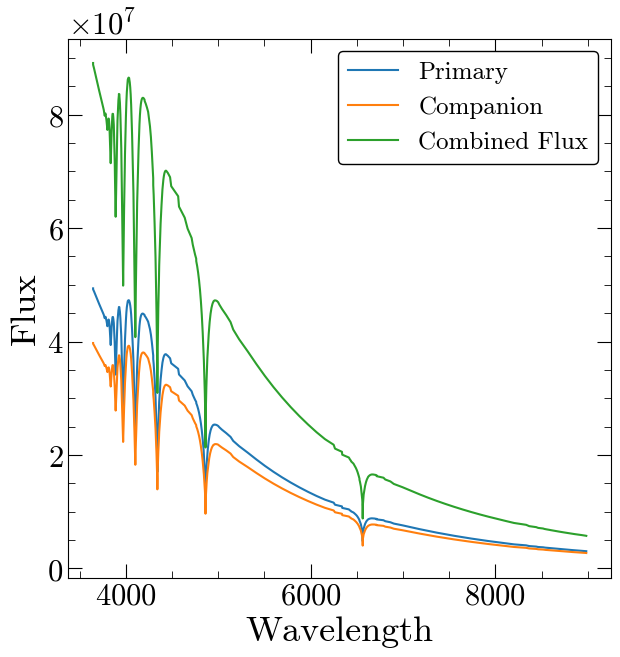

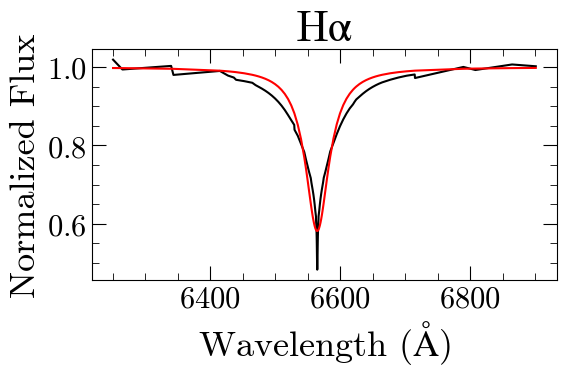

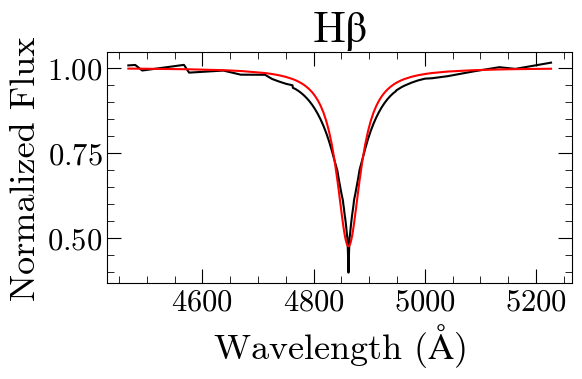

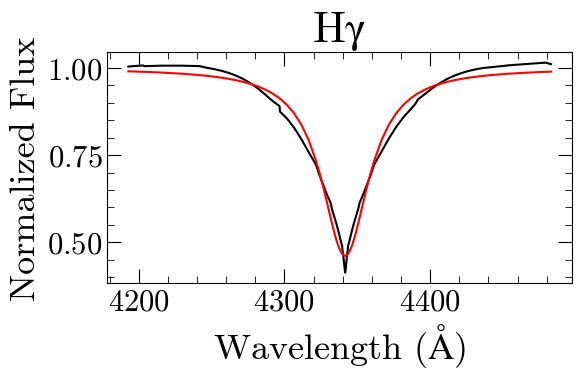

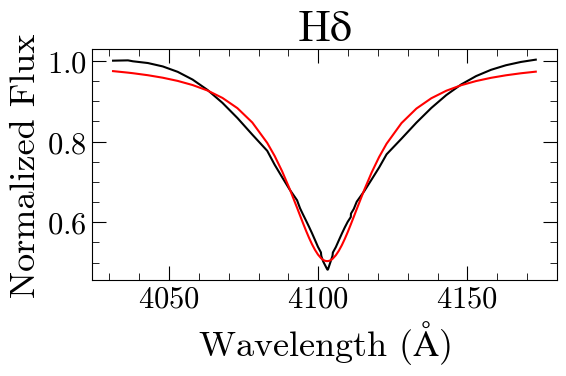

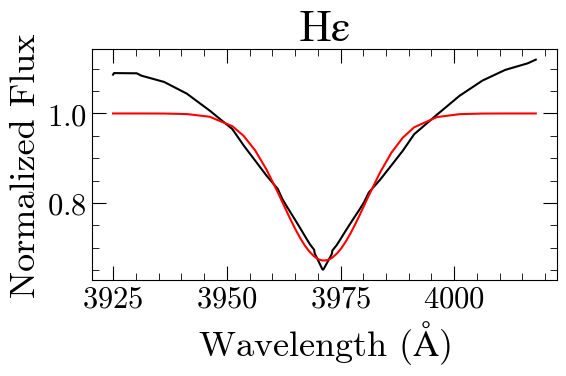

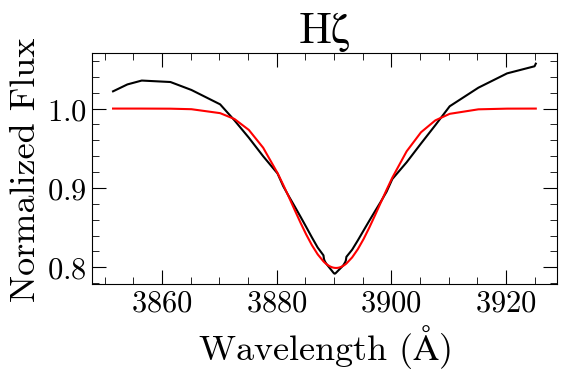

 10%|████▍                                       | 1/10 [00:02<00:18,  2.03s/it]

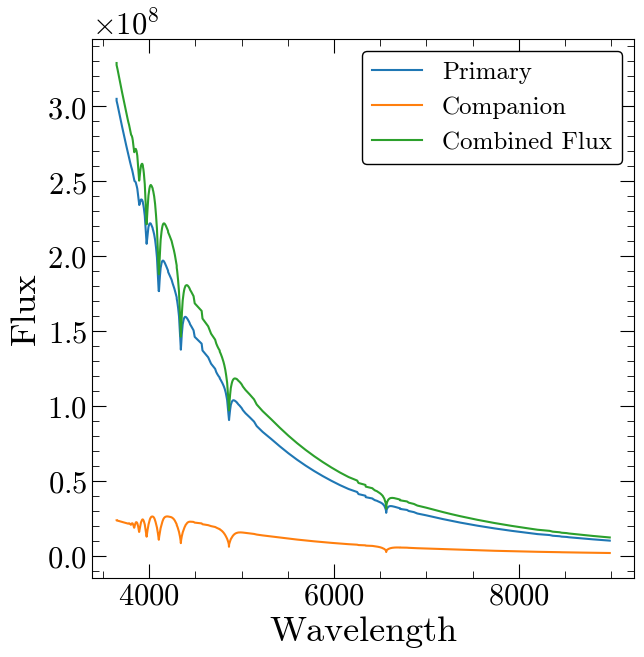

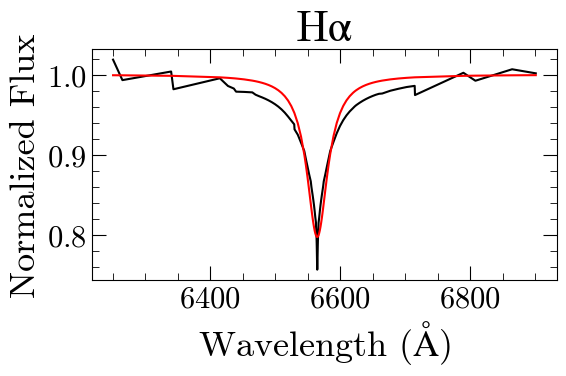

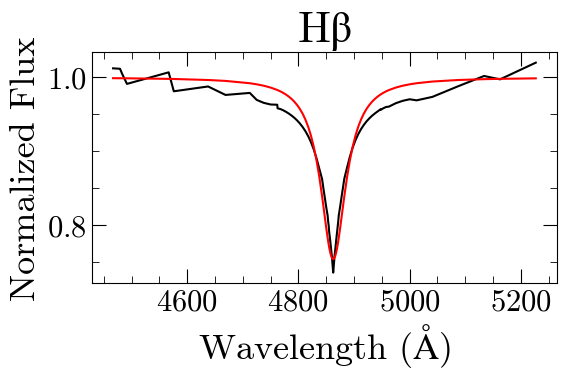

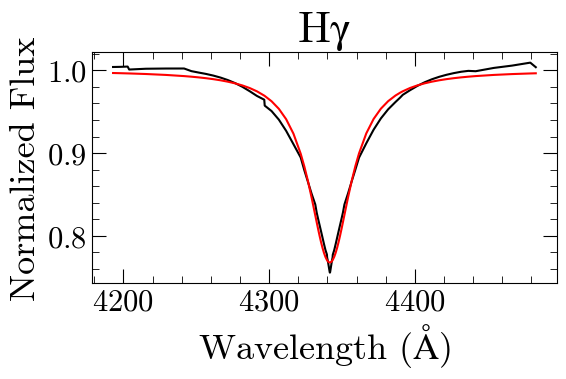

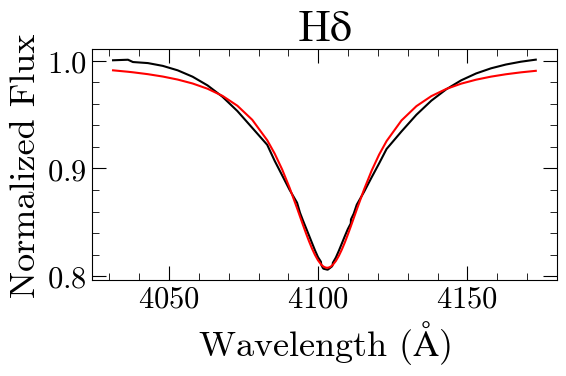

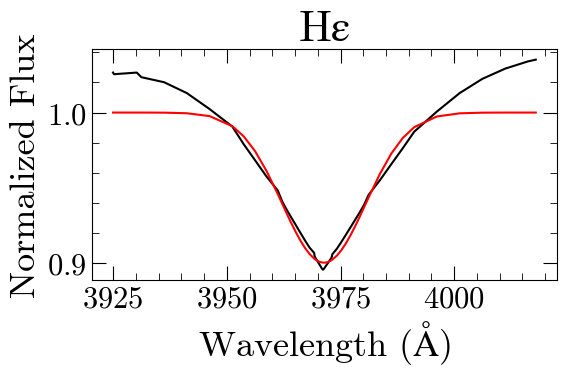

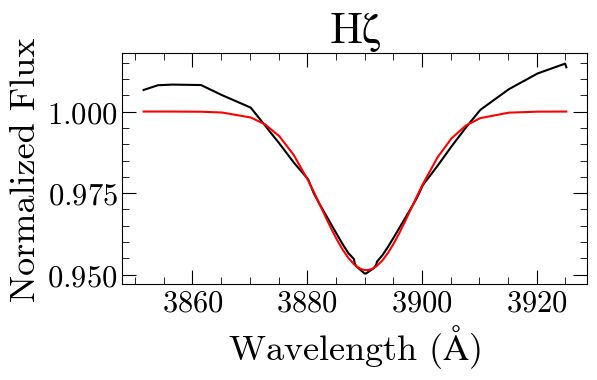

 20%|████████▊                                   | 2/10 [00:03<00:15,  1.88s/it]

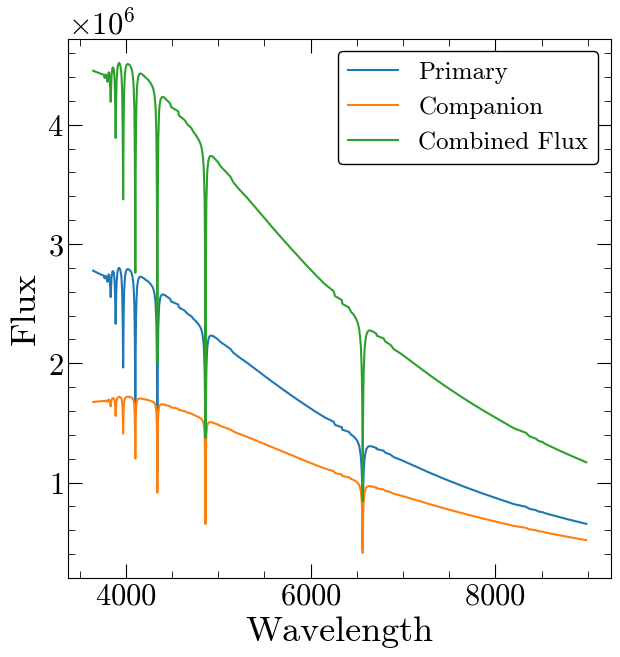

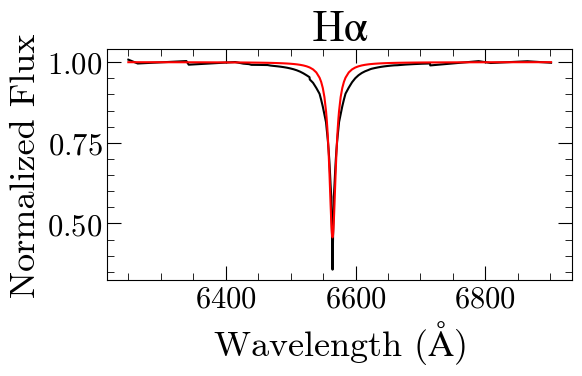

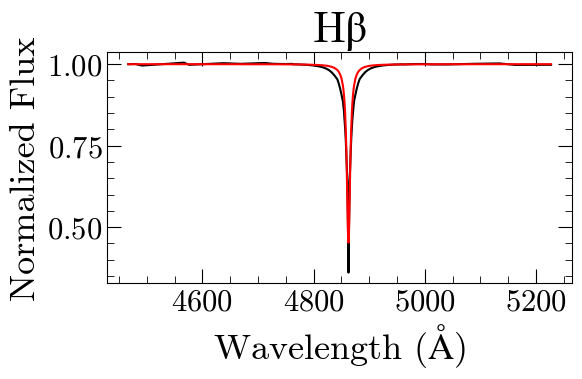

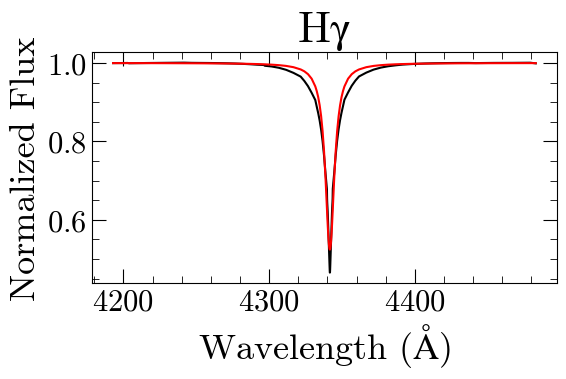

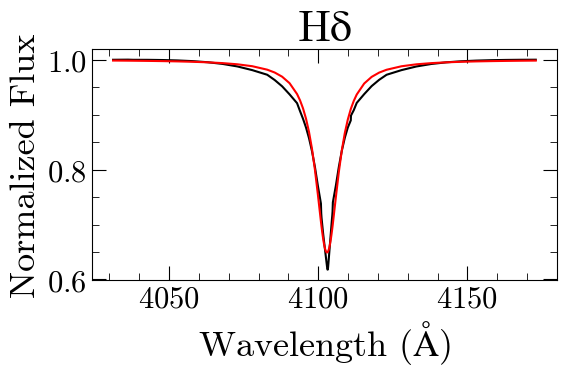

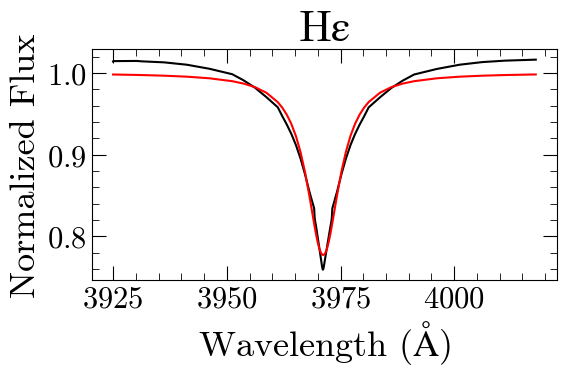

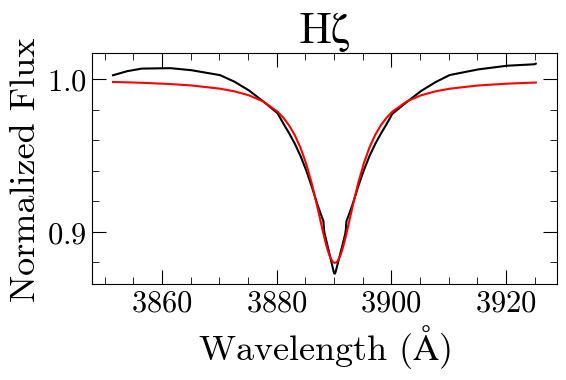

 30%|█████████████▏                              | 3/10 [00:05<00:13,  1.88s/it]

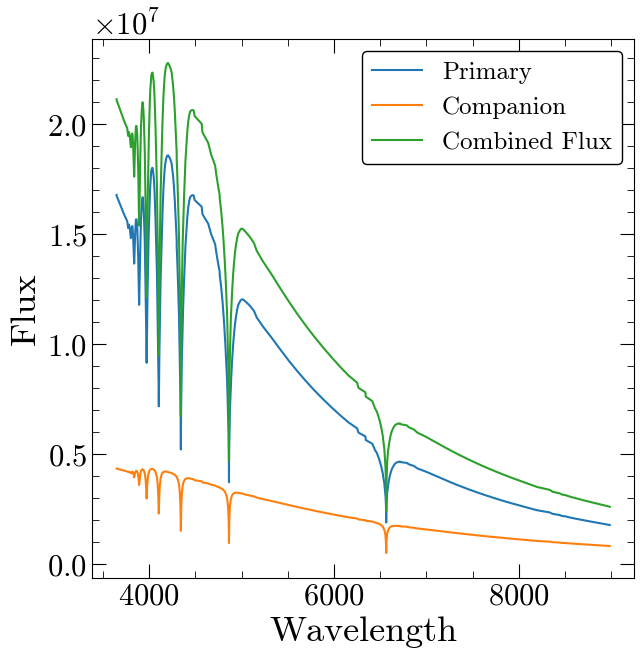

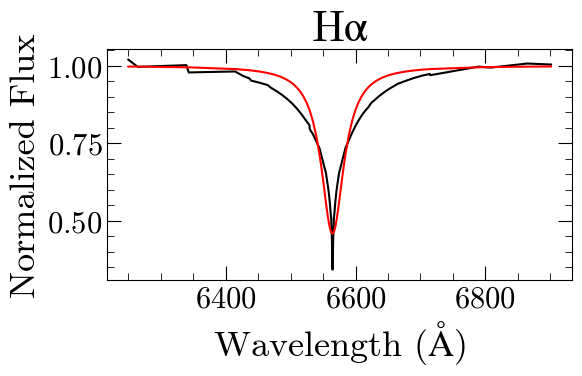

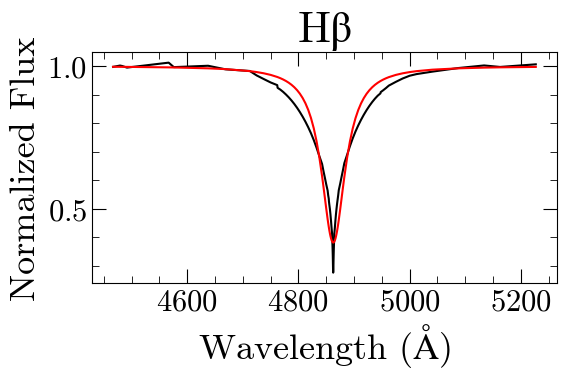

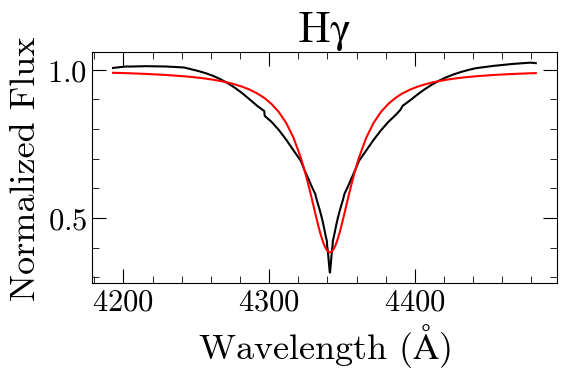

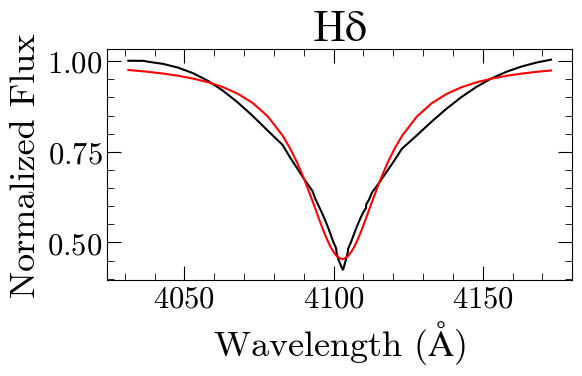

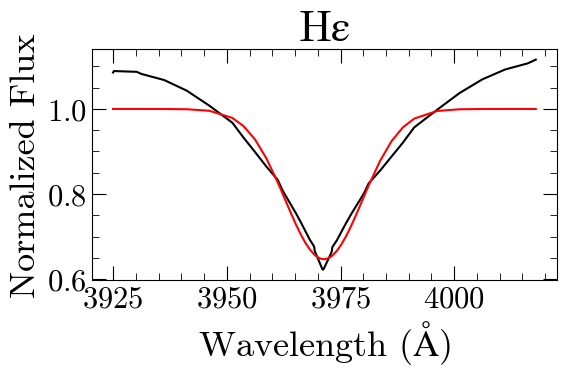

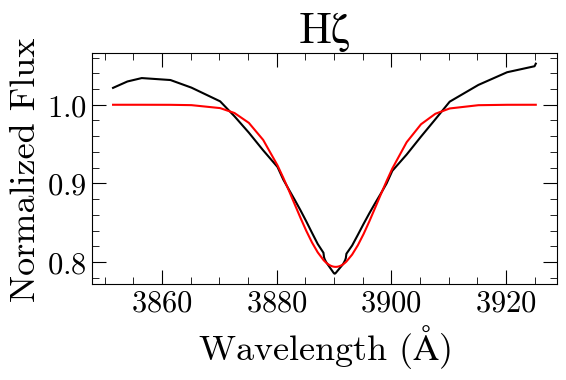

 40%|█████████████████▌                          | 4/10 [00:07<00:11,  1.84s/it]

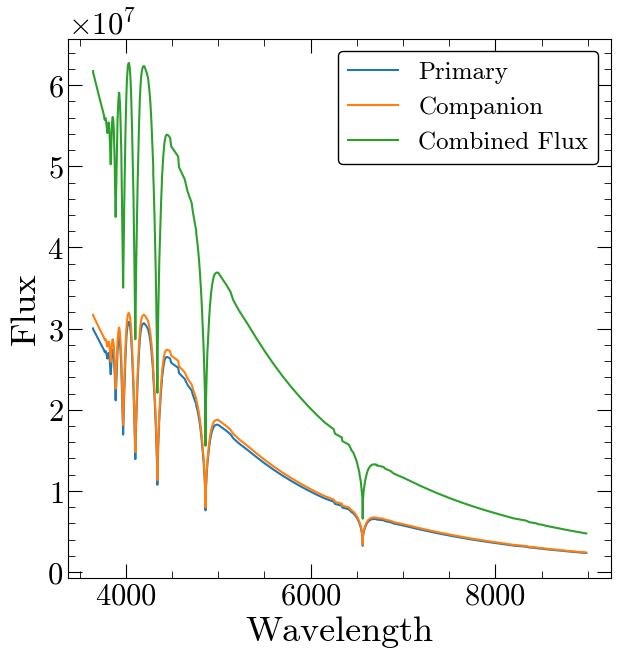

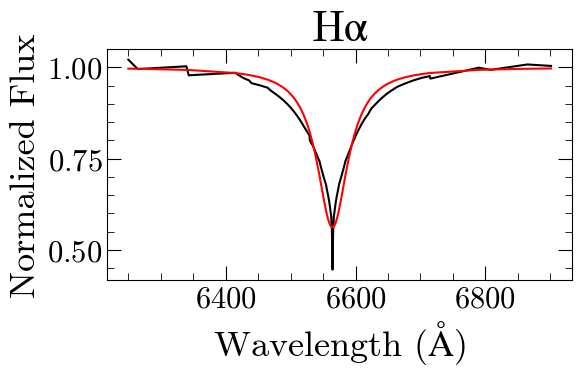

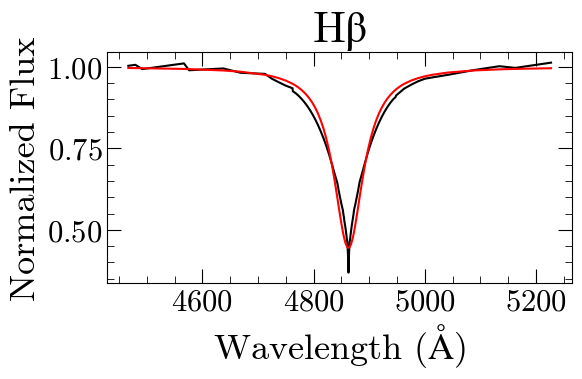

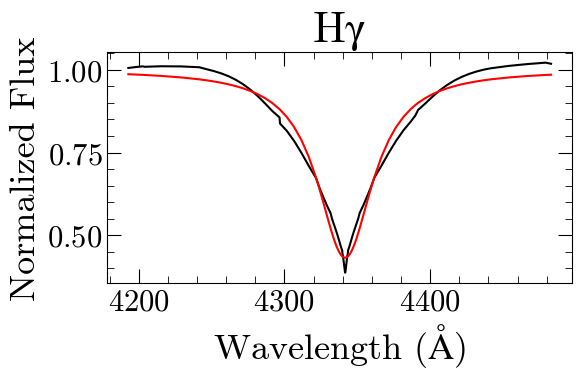

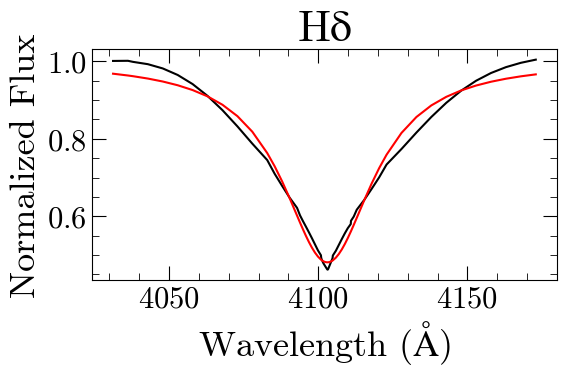

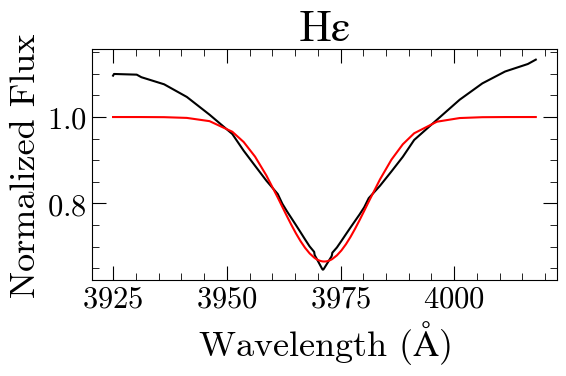

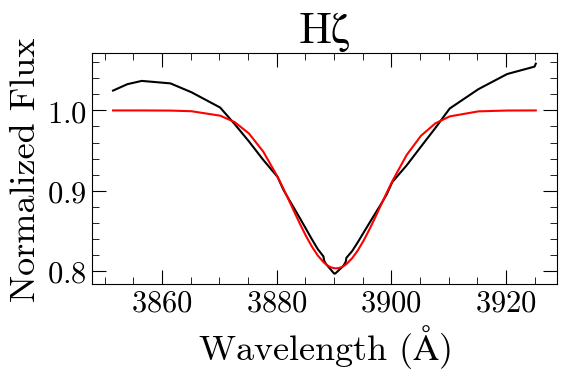

 50%|██████████████████████                      | 5/10 [00:09<00:09,  1.86s/it]

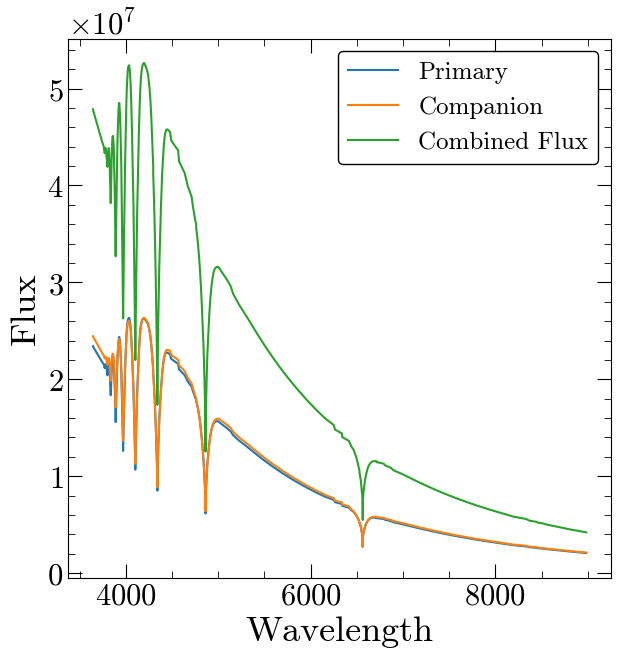

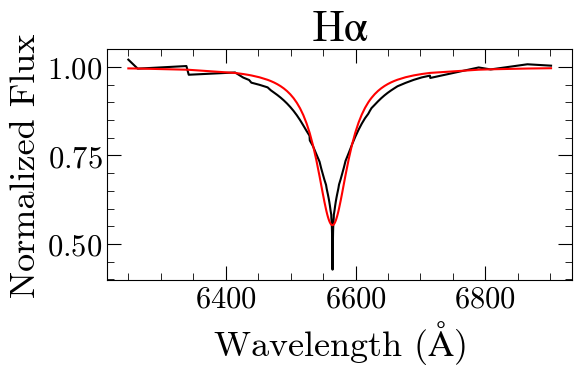

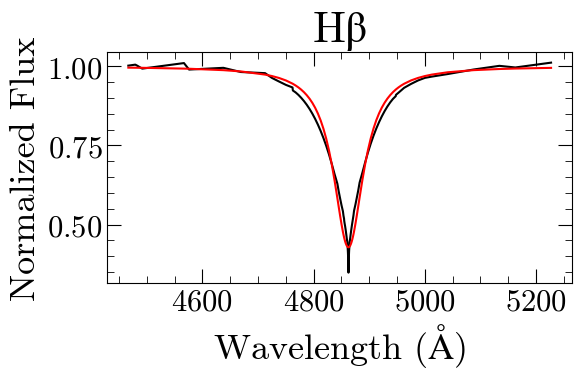

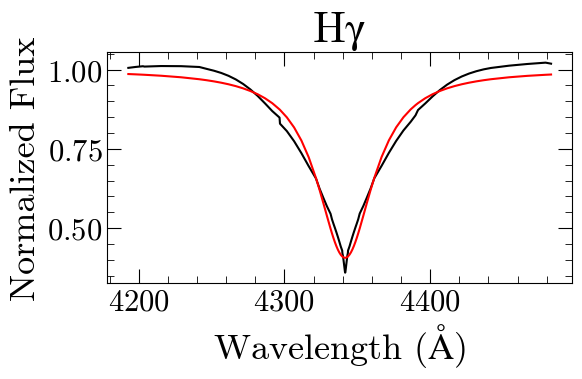

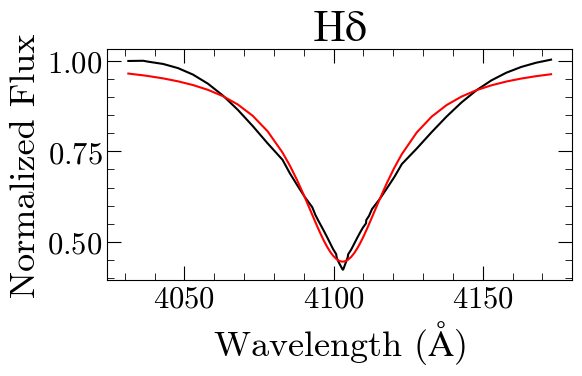

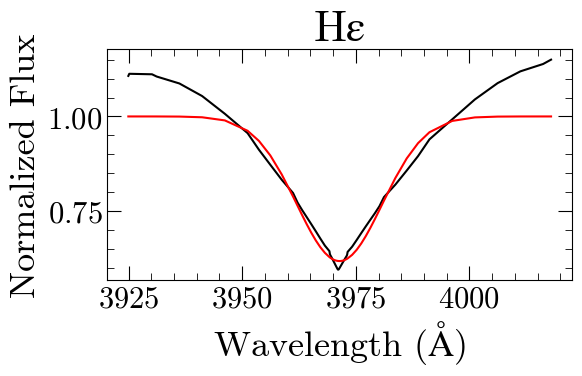

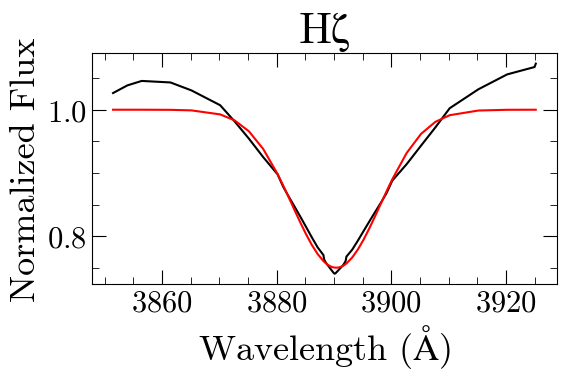

 60%|██████████████████████████▍                 | 6/10 [00:11<00:07,  1.86s/it]

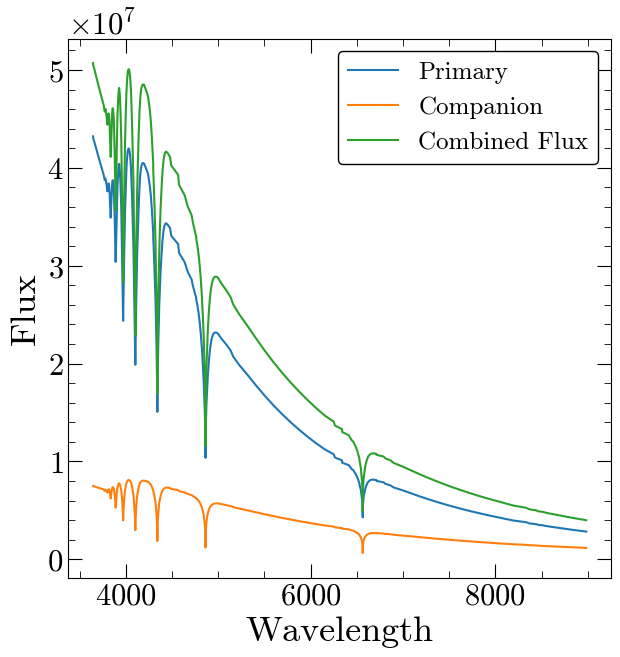

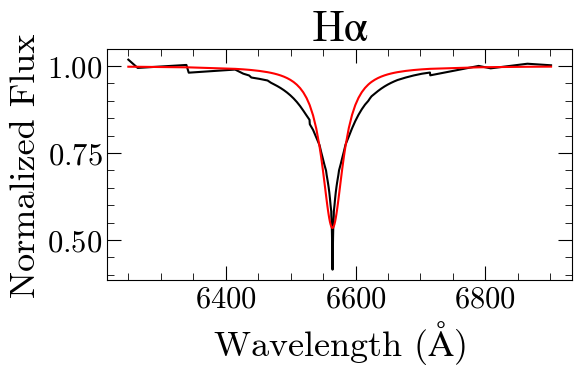

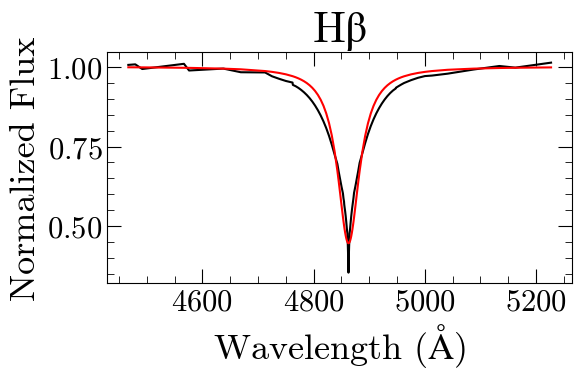

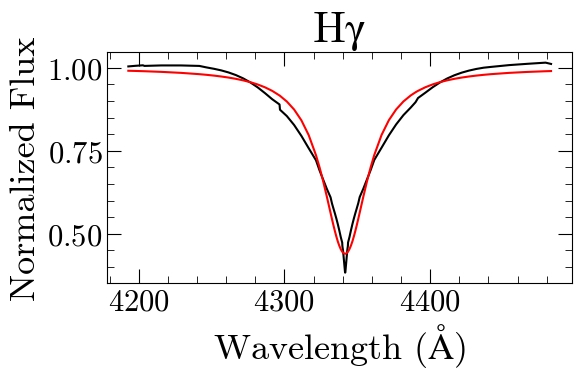

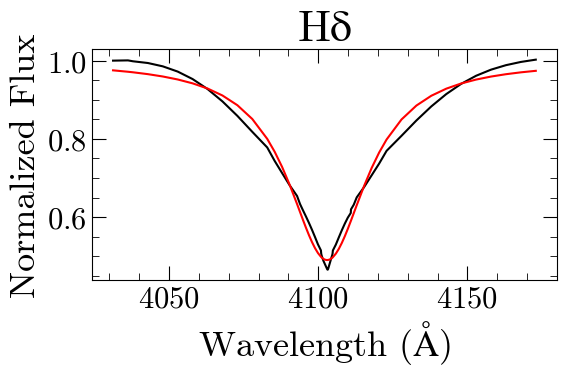

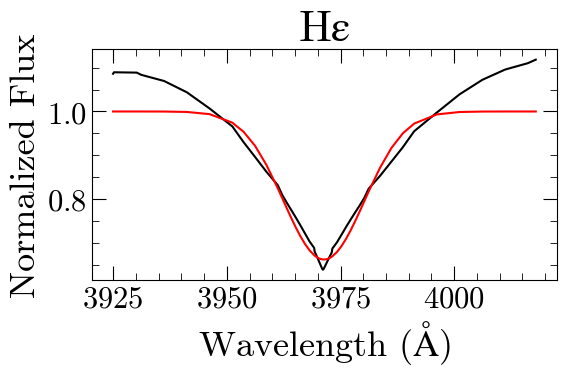

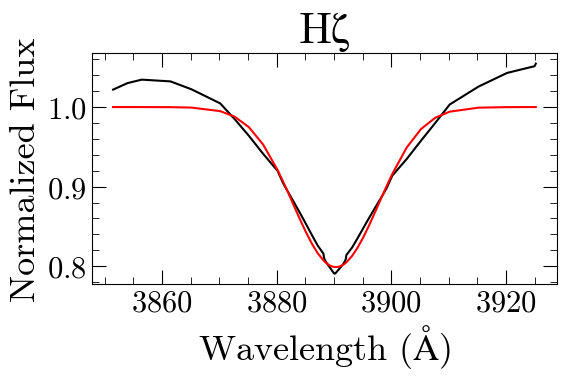

 70%|██████████████████████████████▊             | 7/10 [00:13<00:05,  1.86s/it]

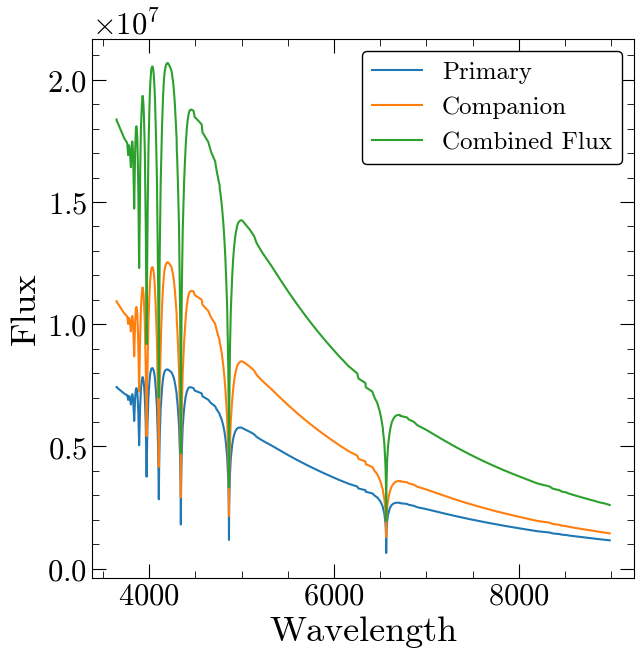

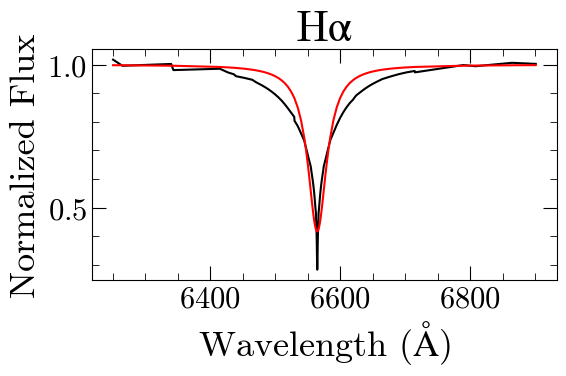

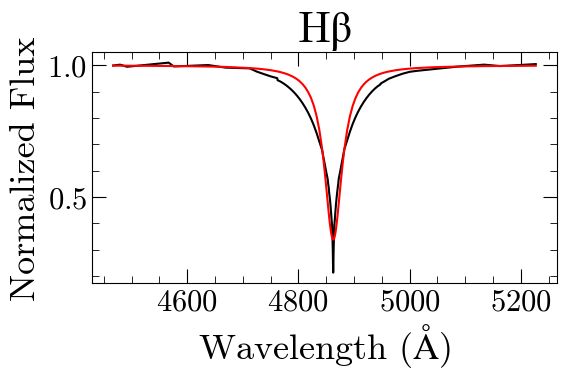

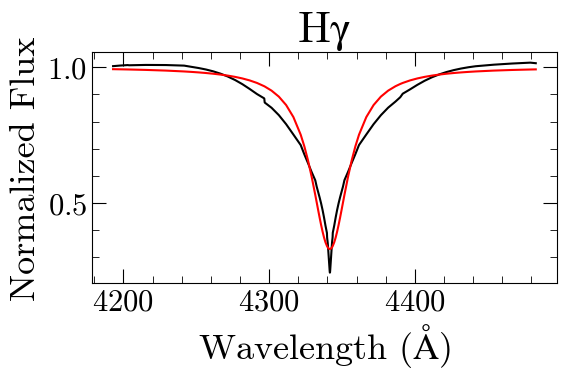

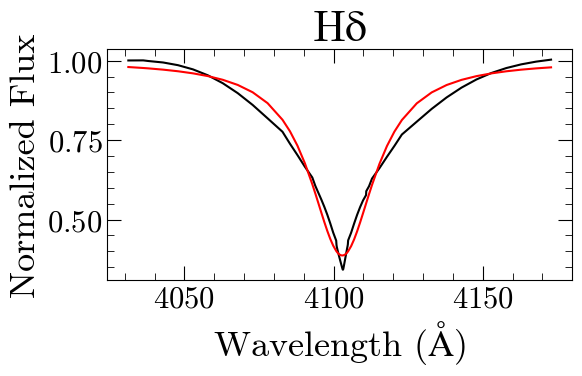

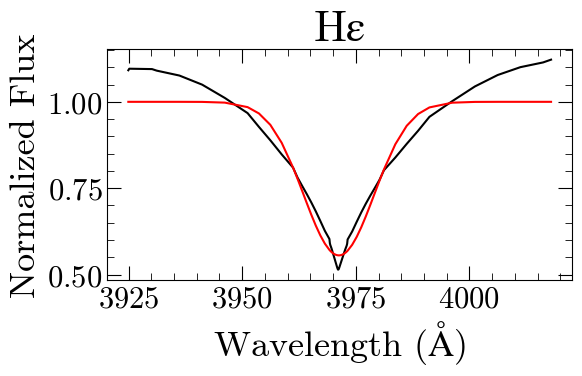

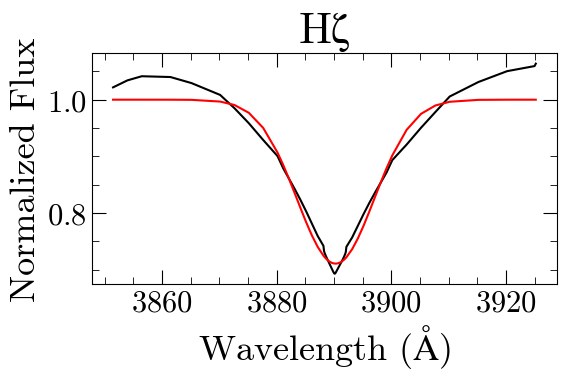

 80%|███████████████████████████████████▏        | 8/10 [00:14<00:03,  1.79s/it]

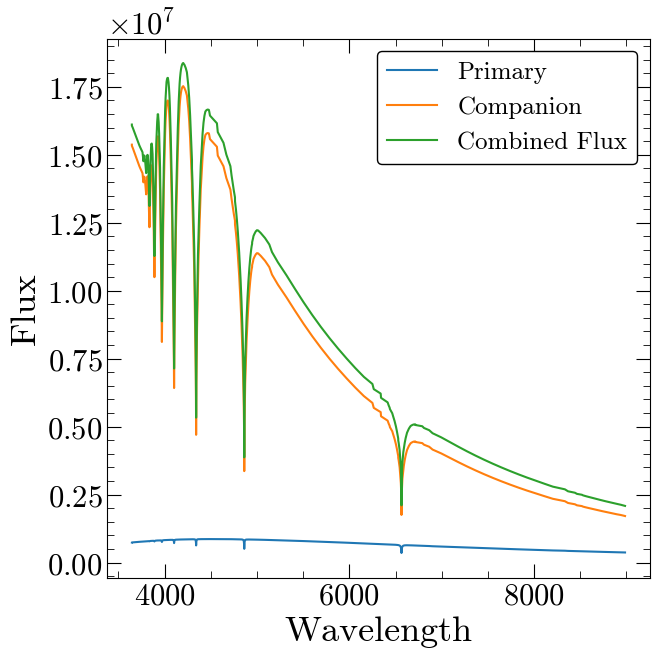

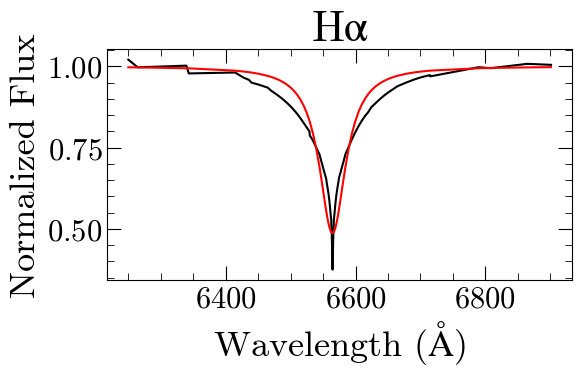

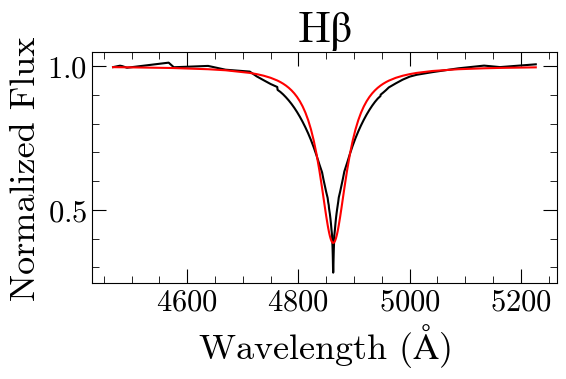

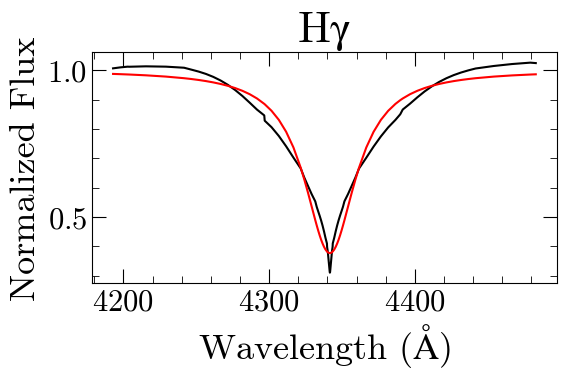

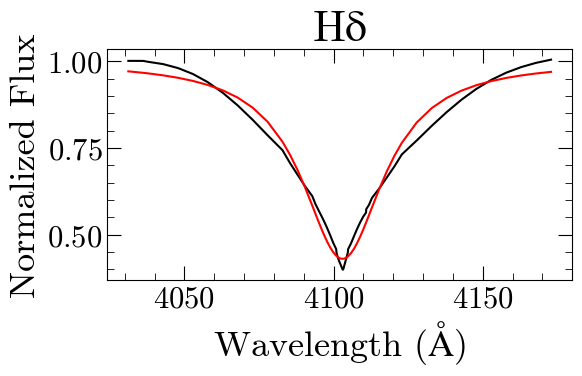

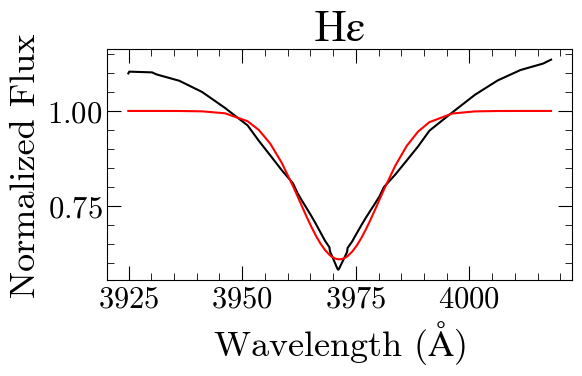

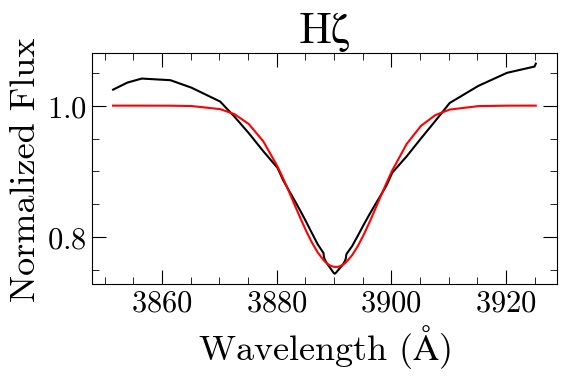

 90%|███████████████████████████████████████▌    | 9/10 [00:16<00:01,  1.71s/it]

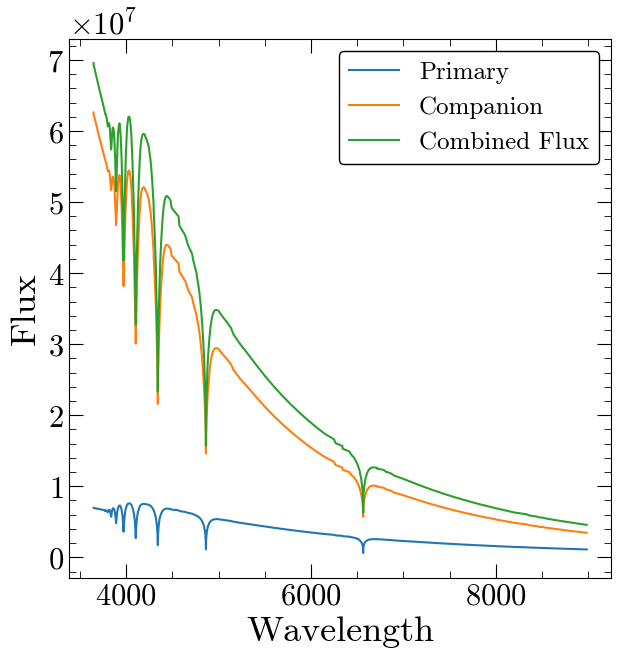

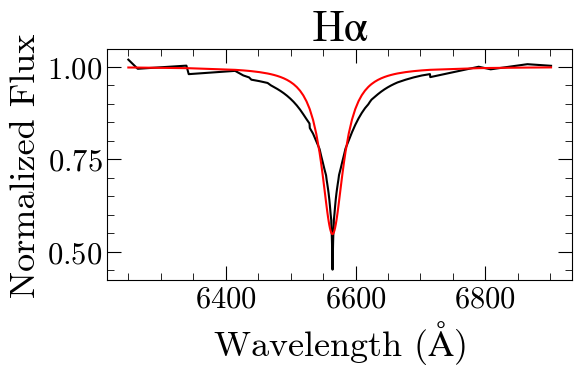

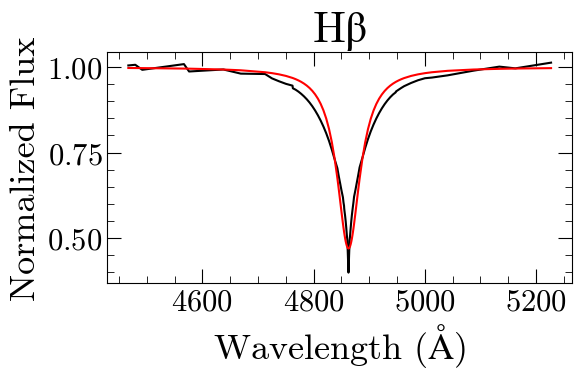

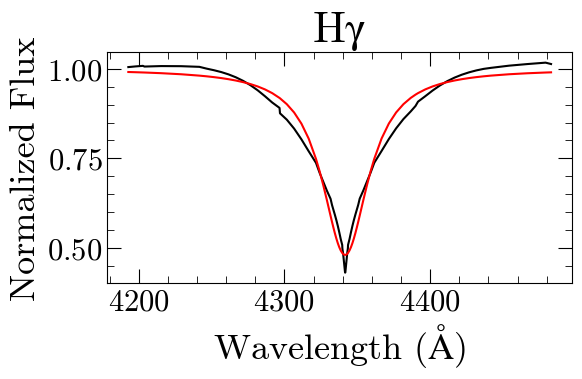

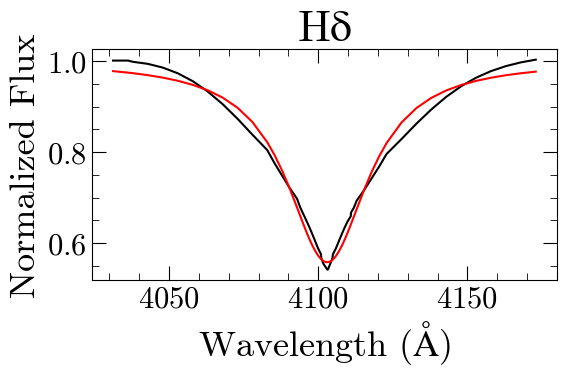

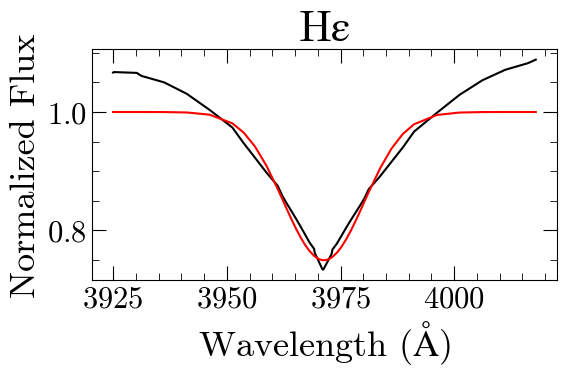

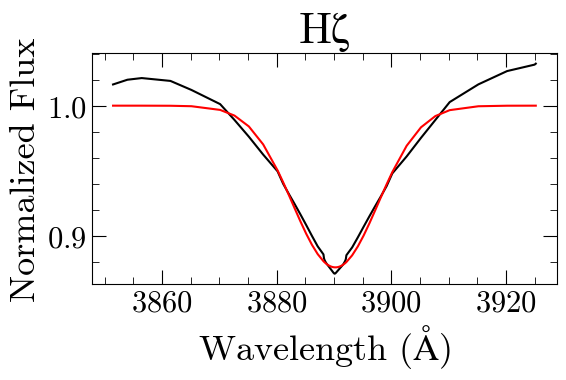

100%|███████████████████████████████████████████| 10/10 [00:18<00:00,  1.81s/it]


In [7]:
#show some fits
test=simulated_wds[:10]
primary_teffs=test['primary_teff']
primary_loggs=test['primary_logg']
primary_vgs=test['primary_vg']
primary_rvs=test['primary_rv']*(10**(-5)) #convert cm/s to km/s
companion_teffs=test['companion_teff']
companion_loggs=test['companion_logg']
companion_vgs=test['companion_vg']
companion_rvs=test['companion_rv']*(10**(-5)) #convert cm/s to km/s
combined_teffs,e_combined_teffs,combined_loggs,e_combined_loggs=fit_binary_spec(primary_teffs,primary_loggs,primary_vgs,primary_rvs,companion_teffs,companion_loggs,
                   companion_vgs,companion_rvs,plot=True)

# Re-fit the Loggs/Teffs for all binary systems and record the apparent Loggs/Teffs

In [8]:
primary_teffs=simulated_wds['primary_teff']
primary_loggs=simulated_wds['primary_logg']
primary_vgs=simulated_wds['primary_vg']
primary_rvs=simulated_wds['primary_rv']*(10**(-5)) #convert cm/s to km/s
companion_teffs=simulated_wds['companion_teff']
companion_loggs=simulated_wds['companion_logg']
companion_vgs=simulated_wds['companion_vg']
companion_rvs=simulated_wds['companion_rv']*(10**(-5)) #convert cm/s to km/s

combined_teffs,e_combined_teffs,combined_loggs,e_combined_loggs=fit_binary_spec(primary_teffs,primary_loggs,primary_vgs,primary_rvs,companion_teffs,companion_loggs,
                   companion_vgs,companion_rvs)

simulated_wds['combined_logg']=combined_loggs
simulated_wds['e_combined_logg']=e_combined_loggs
simulated_wds['combined_teff_spec']=combined_teffs
simulated_wds['e_combined_teff_spec']=e_combined_teffs

100%|█████████████████████████████████████| 10000/10000 [18:43<00:00,  8.90it/s]


In [9]:
#save as a .csv
simulated_wds.to_csv('csv/binaries_effect_sample.csv',index=False)

In [10]:
#read back in
simulated_wds=pd.read_csv('csv/binaries_effect_sample.csv')

# Characterize the impact of binarity on the measured radius, teff, and logg

### Bin the samples and compute the average difference between the  primary and measured parameters in each bin

In [11]:
r_bins=np.append(0,np.arange(0.006,0.029,0.002))
r_bins=np.append(r_bins,0.055)
r_bins=np.round(r_bins,3)
print(r_bins)

#get the range and center for each bin
r_bin_ranges=[]
r_bin_centers=[]
for i in range(len(r_bins)-1):
    array=[r_bins[i],r_bins[i+1]]
    half=0.5*(r_bins[i]+r_bins[i+1])
    r_bin_ranges.append(array)
    r_bin_centers.append(half)
r_bin_nums=np.arange(0,len(r_bin_ranges))

#save the bin info
np.savez('csv/radius_bins',bins=r_bins,ranges=r_bin_ranges,centers=r_bin_centers,nums=r_bin_nums)

[0.    0.006 0.008 0.01  0.012 0.014 0.016 0.018 0.02  0.022 0.024 0.026
 0.028 0.055]


In [12]:
t_bins=np.append(np.arange(4000,46000,1000),100000)
print(t_bins)

#get the range and center for each bin
t_bin_ranges=[]
t_bin_centers=[]
for i in range(len(t_bins)-1):
    array=[t_bins[i],t_bins[i+1]]
    half=0.5*(t_bins[i]+t_bins[i+1])
    t_bin_ranges.append(array)
    t_bin_centers.append(half)
t_bin_nums=np.arange(0,len(t_bin_ranges))

#save the bin info
np.savez('csv/teff_bins',bins=t_bins,ranges=t_bin_ranges,centers=t_bin_centers,nums=t_bin_nums)

[  4000   5000   6000   7000   8000   9000  10000  11000  12000  13000
  14000  15000  16000  17000  18000  19000  20000  21000  22000  23000
  24000  25000  26000  27000  28000  29000  30000  31000  32000  33000
  34000  35000  36000  37000  38000  39000  40000  41000  42000  43000
  44000  45000 100000]


In [13]:
g_bins=np.round(np.append(np.arange(6.9,9.0,0.1),9.1),1)
print(g_bins)

g_bin_ranges=[]
g_bin_centers=[]
for i in range(len(g_bins)-1):
    array=[g_bins[i],g_bins[i+1]]
    half=0.5*(g_bins[i]+g_bins[i+1])
    g_bin_ranges.append(array)
    g_bin_centers.append(half)
g_bin_nums=np.arange(0,len(g_bin_ranges))

#save the bin info
np.savez('csv/logg_bins',bins=g_bins,ranges=g_bin_ranges,centers=g_bin_centers,nums=g_bin_nums)

[6.9 7.  7.1 7.2 7.3 7.4 7.5 7.6 7.7 7.8 7.9 8.  8.1 8.2 8.3 8.4 8.5 8.6
 8.7 8.8 8.9 9.1]


In [14]:
#import the bin information
r_npzfile = np.load('csv/radius_bins.npz')
r_bins = r_npzfile['bins'] 
r_bin_centers = r_npzfile['centers']
r_bin_ranges = r_npzfile['ranges']
r_bin_nums=r_npzfile['nums']

t_npzfile = np.load('csv/teff_bins.npz')
t_bins = t_npzfile['bins'] 
t_bin_centers = t_npzfile['centers']
t_bin_ranges = t_npzfile['ranges']
t_bin_nums=t_npzfile['nums']

g_npzfile = np.load('csv/logg_bins.npz')
g_bins = g_npzfile['bins'] 
g_bin_centers = g_npzfile['centers']
g_bin_ranges = g_npzfile['ranges']
g_bin_nums=g_npzfile['nums']

In [15]:
def bin_by_radius(table,verbose=False):
    #bin by primary radius
    r_bin_ids=[]
    r_bin_id_ranges=[]
    r_bin_id_centers=[]
    for i in range(len(table)):
        radius=table['primary_radius'][i]
        for j in range(len(r_bin_ranges)):
            if r_bin_ranges[j][0]<radius<=r_bin_ranges[j][1]:
                r_bin_ids.append(j)
                r_bin_id_ranges.append(r_bin_ranges[j])
                r_bin_id_centers.append(r_bin_centers[j])
    table['radius_bin_id']=r_bin_ids
    table['radius_bin_range']=r_bin_id_ranges
    table['radius_bin_center']=r_bin_id_centers
    
    if verbose==True:
        for i in range(len(r_bin_ranges)):
            bin_num=r_bin_nums[i]
            bin_range=r_bin_ranges[i]
            tmp=table.query('radius_bin_id==@bin_num')
            print('Bin id=', bin_num,' Bin range=',bin_range,' Rsun, Number of WDs in bin=',len(tmp))
            
    return(table)

In [16]:
def bin_by_teff(table,verbose=False):
    #bin by primary teff
    t_bin_ids=[]
    t_bin_id_ranges=[]
    t_bin_id_centers=[]
    for i in range(len(table)):
        radius=table['primary_teff'][i]
        for j in range(len(t_bin_ranges)):
            if t_bin_ranges[j][0]<radius<=t_bin_ranges[j][1]:
                t_bin_ids.append(j)
                t_bin_id_ranges.append(t_bin_ranges[j])
                t_bin_id_centers.append(t_bin_centers[j])
    table['teff_bin_id']=t_bin_ids
    table['teff_bin_range']=t_bin_id_ranges
    table['teff_bin_center']=t_bin_id_centers
    
    if verbose==True:
        for i in range(len(t_bin_ranges)):
            bin_num=t_bin_nums[i]
            bin_range=t_bin_ranges[i]
            tmp=table.query('teff_bin_id==@bin_num')
            print('Bin id=', bin_num,' Bin range=',bin_range,' K, Number of WDs in bin=',len(tmp))
            
    return(table)

In [17]:
def bin_by_logg(table,verbose=False):
    #bin by primary logg
    g_bin_ids=[]
    g_bin_id_ranges=[]
    g_bin_id_centers=[]
    for i in range(len(table)):
        logg=table['primary_logg'][i]
        for j in range(len(g_bin_ranges)):
            if g_bin_ranges[j][0]<logg<=g_bin_ranges[j][1]:
                g_bin_ids.append(j)
                g_bin_id_ranges.append(g_bin_ranges[j])
                g_bin_id_centers.append(g_bin_centers[j])
    table['logg_bin_id']=g_bin_ids
    table['logg_bin_range']=g_bin_id_ranges
    table['logg_bin_center']=g_bin_id_centers
    
    if verbose==True:
        for i in range(len(g_bin_ranges)):
            bin_num=g_bin_nums[i]
            bin_range=g_bin_ranges[i]
            tmp=table.query('logg_bin_id==@bin_num')
            print('Bin id=', bin_num,' Bin range=',bin_range,' Rsun, Number of WDs in bin=',len(tmp))
            
    return(table)

In [18]:
#bin in primary radius, teff, and logg
simulated_wds=bin_by_radius(simulated_wds,verbose=True)
print('')
simulated_wds=bin_by_teff(simulated_wds,verbose=True)
print('')
simulated_wds=bin_by_logg(simulated_wds,verbose=True)


Bin id= 0  Bin range= [0.    0.006]  Rsun, Number of WDs in bin= 30
Bin id= 1  Bin range= [0.006 0.008]  Rsun, Number of WDs in bin= 153
Bin id= 2  Bin range= [0.008 0.01 ]  Rsun, Number of WDs in bin= 712
Bin id= 3  Bin range= [0.01  0.012]  Rsun, Number of WDs in bin= 1707
Bin id= 4  Bin range= [0.012 0.014]  Rsun, Number of WDs in bin= 4490
Bin id= 5  Bin range= [0.014 0.016]  Rsun, Number of WDs in bin= 1708
Bin id= 6  Bin range= [0.016 0.018]  Rsun, Number of WDs in bin= 542
Bin id= 7  Bin range= [0.018 0.02 ]  Rsun, Number of WDs in bin= 280
Bin id= 8  Bin range= [0.02  0.022]  Rsun, Number of WDs in bin= 177
Bin id= 9  Bin range= [0.022 0.024]  Rsun, Number of WDs in bin= 79
Bin id= 10  Bin range= [0.024 0.026]  Rsun, Number of WDs in bin= 54
Bin id= 11  Bin range= [0.026 0.028]  Rsun, Number of WDs in bin= 57
Bin id= 12  Bin range= [0.028 0.055]  Rsun, Number of WDs in bin= 11

Bin id= 0  Bin range= [4000 5000]  K, Number of WDs in bin= 1
Bin id= 1  Bin range= [5000 6000]  K, N

In [19]:
#save as a .csv
simulated_wds.to_csv('csv/binaries_effect_sample.csv',index=False)

In [20]:
#read back in
simulated_wds=pd.read_csv('csv/binaries_effect_sample.csv')

In [21]:
def binned_med_std(table,parameter):
                    
    #calculate the mean/std x=combined radius/teff for each bin
    if parameter=='radius_sdss' or parameter=='radius_gaia':
        bin_nums=r_bin_nums
        bin_ranges=r_bin_ranges
        bin_centers=r_bin_centers
        bin_id_key='radius_bin_id'
        bin_name='radius'
    if parameter=='teff_sdss' or parameter=='teff_gaia':
        bin_nums=t_bin_nums
        bin_ranges=t_bin_ranges
        bin_centers=t_bin_centers
        bin_id_key='teff_bin_id'
        bin_name='teff'
    if parameter=='logg':
        bin_nums=g_bin_nums
        bin_ranges=g_bin_ranges
        bin_centers=g_bin_centers
        bin_id_key='logg_bin_id'
        bin_name='logg'
    
    
    med_xs=[]
    std_xs=[]
    num_obs_per_bin=[]
    for i in range(len(bin_nums)):
        tmp=table.query(bin_id_key+'=='+str(bin_nums[i]))
        if parameter=='radius_sdss':
            x=tmp['primary_radius']-tmp['combined_radius_sdss']
        if parameter=='radius_gaia':
            x=tmp['primary_radius']-tmp['combined_radius_gaia']
        if parameter=='teff_sdss':
            x=tmp['primary_teff']-tmp['combined_teff_sdss']
        if parameter=='teff_gaia':
            x=tmp['primary_teff']-tmp['combined_teff_gaia']
        if parameter=='logg':
            x=tmp['primary_logg']-tmp['combined_logg']
        if len(x)>0:
            #calculate median and std of x
            med_x=np.nanmedian(x)#nanmean(x)
            std_x=np.nanstd(x)
        else: #if bin is empty fill with nan values
            med_x=np.nan
            std_x=np.nan
        #record results
        med_xs.append(med_x)
        std_xs.append(std_x)
        #record how many observations used in averaging
        num_obs=len(tmp)
        num_obs_per_bin.append(num_obs)

    #convert bin ranges to string
    bin_ranges_str=[]
    for i in range(len(bin_ranges)):
        bin_ranges_str.append(str(bin_ranges[i]))
    
    #save parameters
    final_avg_table=pd.DataFrame()
    final_avg_table['bin_id']=bin_nums
    final_avg_table['bin_range']=bin_ranges_str
    final_avg_table['bin_center']=bin_centers
    
    final_avg_table['med_difference']=med_xs
    final_avg_table['std_difference']=std_xs
    final_avg_table['num_obs_per_bin']=num_obs_per_bin
    
    #re-order by bin_id
    final_avg_table=final_avg_table.sort_values(by=['bin_id'])
    
    return(final_avg_table)

In [22]:
#get the median and std of the difference between the primary and measured values for each radius/teff bin
radius_sdss=binned_med_std(simulated_wds,'radius_sdss')
teff_sdss=binned_med_std(simulated_wds,'teff_sdss')
radius_gaia=binned_med_std(simulated_wds,'radius_gaia')
teff_gaia=binned_med_std(simulated_wds,'teff_gaia')
logg=binned_med_std(simulated_wds,'logg')

In [23]:
#save these tables, to characterize the effects of binaries on measured parameters
#we will draw a difference from a normal distrbution with mean/std from these tables in nb06
radius_sdss.to_csv('csv/binaries_effect_radius_sdss.csv',index=False)
teff_sdss.to_csv('csv/binaries_effect_teff_sdss.csv',index=False)
radius_gaia.to_csv('csv/binaries_effect_radius_gaia.csv',index=False)
teff_gaia.to_csv('csv/binaries_effect_teff_gaia.csv',index=False)
logg.to_csv('csv/binaries_effect_logg.csv',index=False)

# Impact on photometry

Text(0, 0.5, 'Primary-Measured Teff (K)')

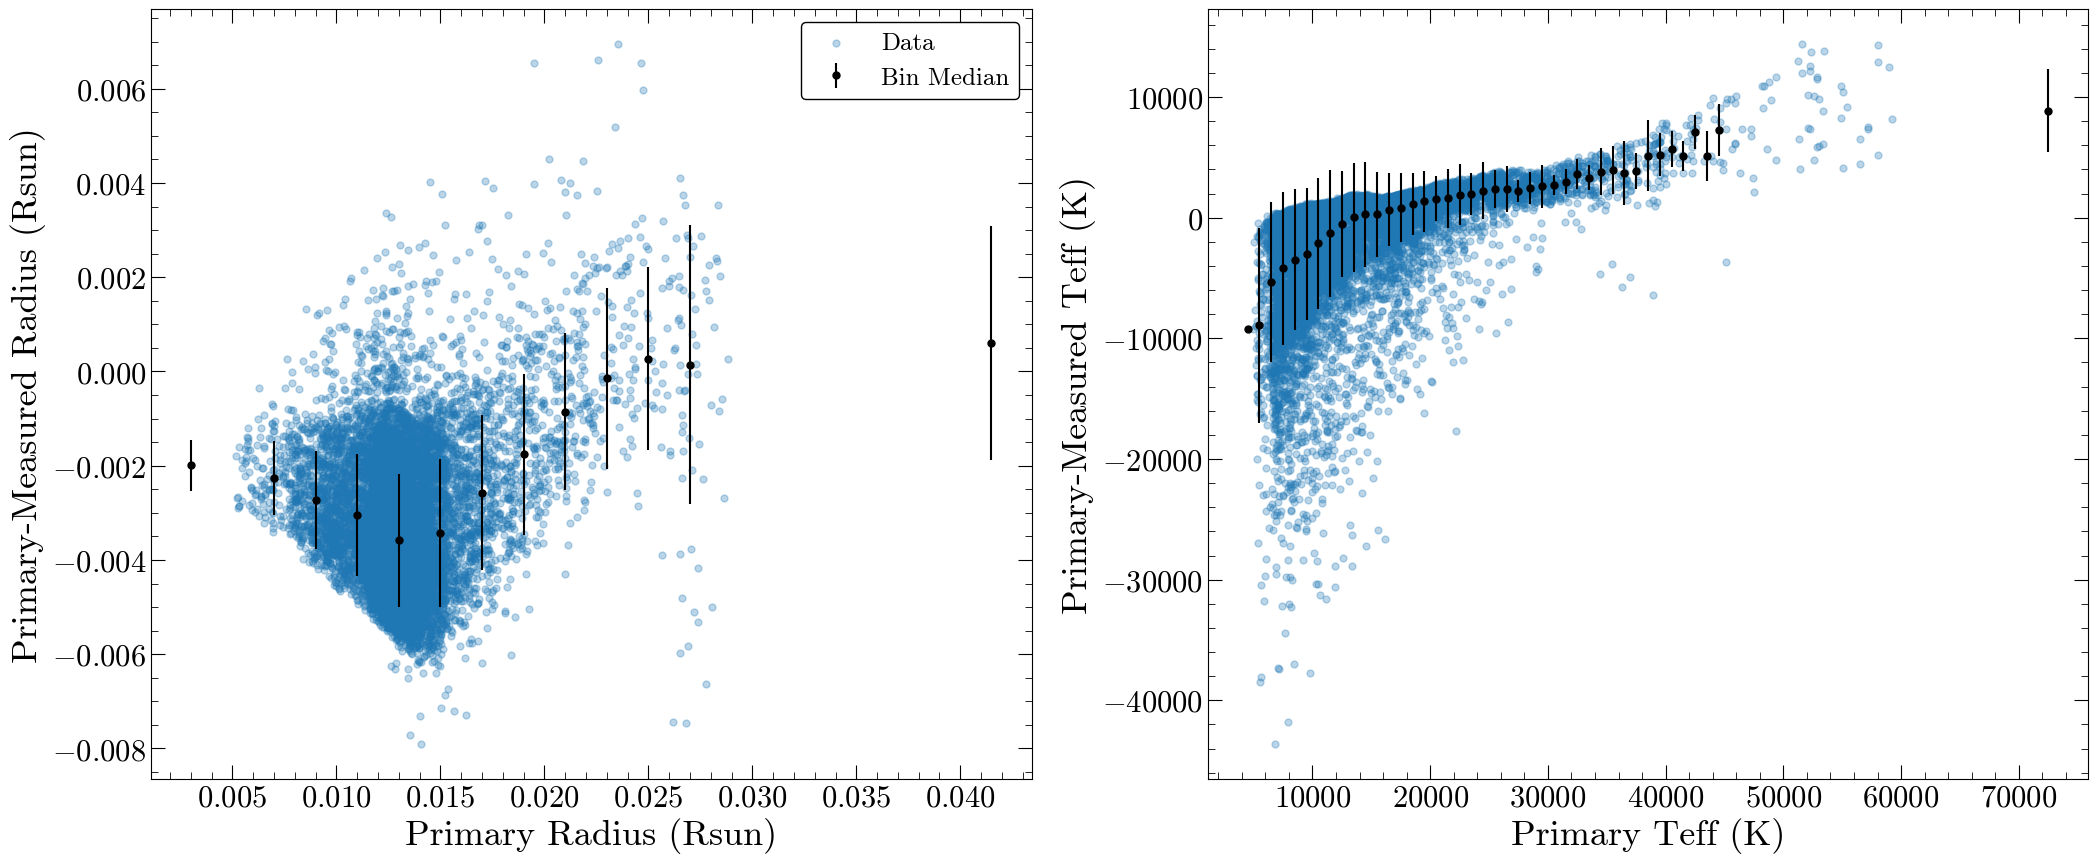

In [24]:
#SDSS

#plot the effect of the binaries on measuring the radius/teff
fig, (ax1,ax2) =plt.subplots(1,2,figsize=(25,10))
ax1.scatter(simulated_wds['primary_radius'],simulated_wds['primary_radius']-simulated_wds['combined_radius_sdss'],alpha=0.3,label='Data')
ax1.errorbar(radius_sdss['bin_center'],radius_sdss['med_difference'], yerr=radius_sdss['std_difference'],
             fmt='o', color='black', ecolor = 'black',label='Bin Median')
ax1.set_xlabel('Primary Radius (Rsun)')
ax1.set_ylabel('Primary-Measured Radius (Rsun)')
ax1.legend()

ax2.scatter(simulated_wds['primary_teff'],simulated_wds['primary_teff']-simulated_wds['combined_teff_sdss'],alpha=0.3)
ax2.errorbar(teff_sdss['bin_center'],teff_sdss['med_difference'], yerr=teff_sdss['std_difference'],
             fmt='o', color='black', ecolor = 'black')
ax2.set_xlabel('Primary Teff (K)')
ax2.set_ylabel('Primary-Measured Teff (K)')


Text(0, 0.5, 'Primary-Measured Teff (K)')

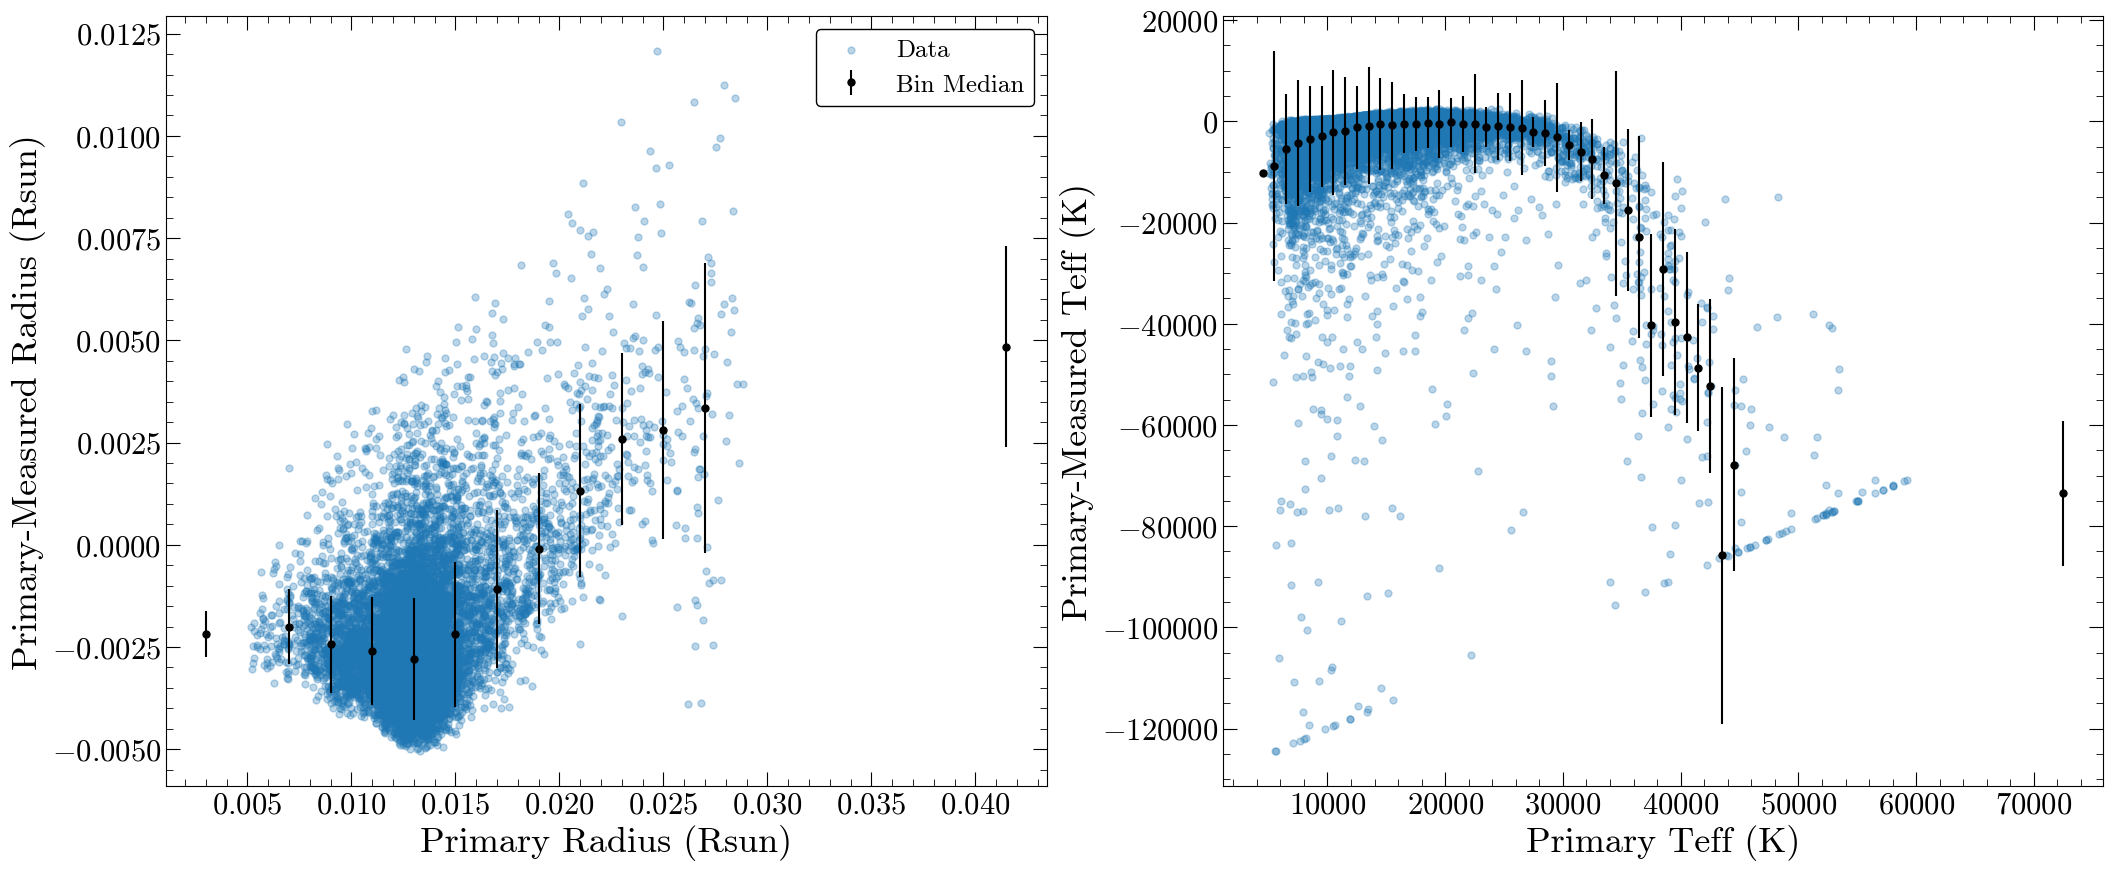

In [25]:
#Gaia

#plot the effect of the binaries on measuring the radius/teff
fig, (ax1,ax2) =plt.subplots(1,2,figsize=(25,10))
ax1.scatter(simulated_wds['primary_radius'],simulated_wds['primary_radius']-simulated_wds['combined_radius_gaia'],alpha=0.3,label='Data')
ax1.errorbar(radius_gaia['bin_center'],radius_gaia['med_difference'], yerr=radius_gaia['std_difference'],
             fmt='o', color='black', ecolor = 'black',label='Bin Median')
ax1.set_xlabel('Primary Radius (Rsun)')
ax1.set_ylabel('Primary-Measured Radius (Rsun)')
ax1.legend()

ax2.scatter(simulated_wds['primary_teff'],simulated_wds['primary_teff']-simulated_wds['combined_teff_gaia'],alpha=0.3)
ax2.errorbar(teff_gaia['bin_center'],teff_gaia['med_difference'], yerr=teff_gaia['std_difference'],
             fmt='o', color='black', ecolor = 'black')
ax2.set_xlabel('Primary Teff (K)')
ax2.set_ylabel('Primary-Measured Teff (K)')


# Impact on Spectroscopy

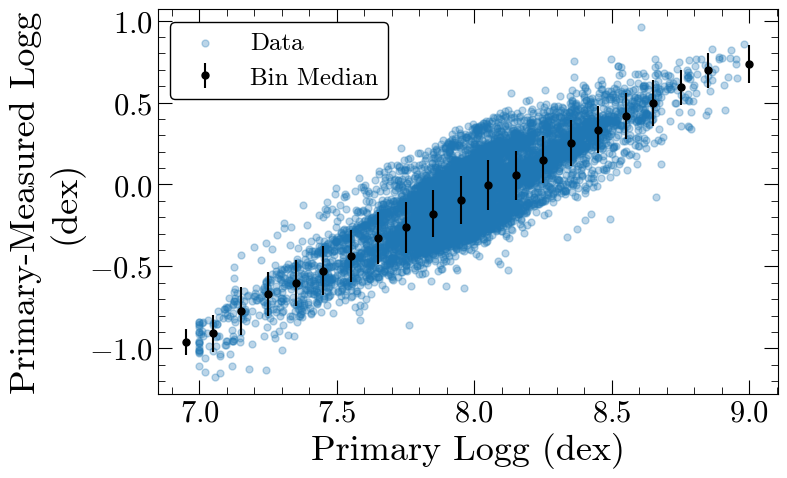

In [26]:
#plot the effect of the binaries on measuring the logg/teff
fig, (ax1) =plt.subplots(1,1,figsize=(8,5))
ax1.scatter(simulated_wds['primary_logg'],simulated_wds['primary_logg']-simulated_wds['combined_logg'],alpha=0.3,label='Data')
ax1.errorbar(logg['bin_center'],logg['med_difference'], yerr=logg['std_difference'],
             fmt='o', color='black', ecolor = 'black',label='Bin Median')
ax1.set_xlabel('Primary Logg (dex)')
ax1.set_ylabel('Primary-Measured Logg\n(dex)')
ax1.legend()


# Final Plot

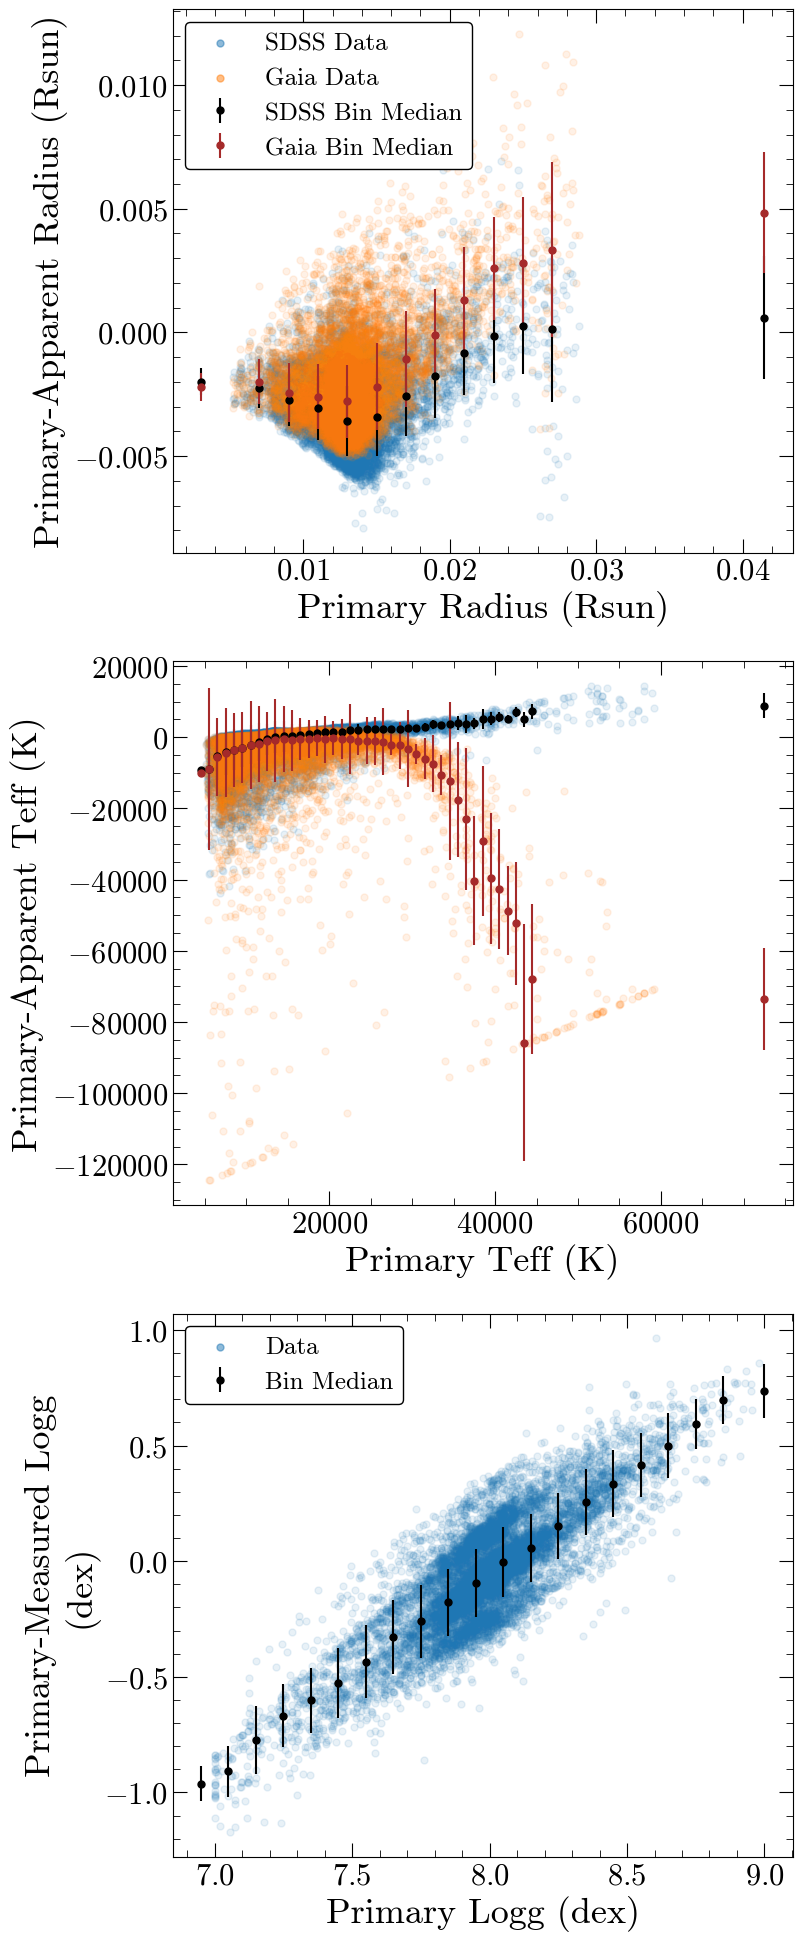

In [27]:
fig, ((ax1),(ax2),(ax3)) =plt.subplots(3,1,figsize=(8,24))
ax1.scatter(simulated_wds['primary_radius'],simulated_wds['primary_radius']-simulated_wds['combined_radius_sdss'],rasterized=True,alpha=0.1,label='SDSS Data')
ax1.errorbar(radius_sdss['bin_center'],radius_sdss['med_difference'], yerr=radius_sdss['std_difference'],
             fmt='o', color='black', ecolor = 'black',label='SDSS Bin Median')
ax1.scatter(simulated_wds['primary_radius'],simulated_wds['primary_radius']-simulated_wds['combined_radius_gaia'],rasterized=True,alpha=0.1,label='Gaia Data')
ax1.errorbar(radius_gaia['bin_center'],radius_gaia['med_difference'], yerr=radius_gaia['std_difference'],
             fmt='o', color='brown', ecolor = 'brown',label='Gaia Bin Median')
ax1.set_xlabel('Primary Radius (Rsun)')
ax1.set_ylabel('Primary-Apparent Radius (Rsun)')

ax2.scatter(simulated_wds['primary_teff'],simulated_wds['primary_teff']-simulated_wds['combined_teff_sdss'],rasterized=True,alpha=0.1,label='SDSS Data')
ax2.errorbar(teff_sdss['bin_center'],teff_sdss['med_difference'], yerr=teff_sdss['std_difference'],
             fmt='o', color='black', ecolor = 'black',label='SDSS Bin Median')
ax2.scatter(simulated_wds['primary_teff'],simulated_wds['primary_teff']-simulated_wds['combined_teff_gaia'],rasterized=True,alpha=0.1,label='Gaia Data')
ax2.errorbar(teff_gaia['bin_center'],teff_gaia['med_difference'], yerr=teff_gaia['std_difference'],
             fmt='o', color='brown', ecolor = 'brown',label='Gaia Bin Median')
ax2.set_xlabel('Primary Teff (K)')
ax2.set_ylabel('Primary-Apparent Teff (K)')

ax3.scatter(simulated_wds['primary_logg'],simulated_wds['primary_logg']-simulated_wds['combined_logg'],rasterized=True,alpha=0.1,label='Data')
ax3.errorbar(logg['bin_center'],logg['med_difference'], yerr=logg['std_difference'],
             fmt='o', color='black', ecolor = 'black',label='Bin Median')
ax3.set_xlabel('Primary Logg (dex)')
ax3.set_ylabel('Primary-Measured Logg\n(dex)')


#change the legend alpha
lgnd = ax1.legend()
lgnd.legend_handles[0]._alpha = [0.5]
lgnd.legend_handles[1]._alpha = [0.5]

lgnd = ax3.legend()
lgnd.legend_handles[0]._alpha = [0.5]

plt.savefig('binaries.pdf', dpi=300)